<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [2]:
import re
import time
import random
import numpy as np
import scipy as sp
import pickle
import cv2
import hashlib

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.4.1
Eager mode: True
Found GPU at: /device:GPU:0


In [4]:
def show_image(image, title=None):
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(image.reshape(28, 28), cmap='Greys')
  if title is not None:
    plt.title(title)
  plt.show()

In [5]:
def show_prediction(image, label, prediction):
  title = "Prediction: %s / Truth: %s" % (np.argmax(prediction), label)
  show_image(image, title)

In [6]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    height_zoom = size[1] / cam.shape[0]
    width_zoom = size[0] / cam.shape[1]
    heatmap = sp.ndimage.zoom(cam, (height_zoom, width_zoom), order=2)
 
  return heatmap

In [7]:
def show_heatmap(img, cam, size, resize=True, title=None):
  img = img.reshape(size[0], size[1])
  heatmap = get_heatmap(cam, size, resize)

  # plot
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(img, alpha=0.5, cmap='Greys')
  plt.imshow(heatmap, cmap='jet', alpha=0.5)
  
  if title is not None:
    plt.title(title)
  
  plt.show()  

In [8]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [9]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [10]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [11]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [118]:
def get_sample(test_set, idx=-1):
  idx = random.randint(0, len(test_set[0])) if idx < 0 else idx
  test_image = test_set[0][idx]
  test_label = np.argmax(test_set[1][idx])

  return test_image, test_label

In [12]:
def predict(model, image):
  return model.predict(np.expand_dims(image, 0))

In [119]:
def get_prediction(model, test_set, idx=-1):
  image, label = get_sample(test_set, idx)
  prediction = predict(model, image)

  return image, label, prediction, idx

In [14]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

#MNIST

In [15]:
mnist_num_classes = 10
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(mnist_num_classes, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.5),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

11493376/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Epoch 1/15
422/422 [==============================] - 35s 12ms/step - loss: 0.9645 - accuracy: 0.6865 - val_loss: 0.1308 - val_accuracy: 0.9622
Epoch 2/15
422/422 [==============================] - 4s 11ms/step - loss: 0.1933 - accuracy: 0.9405 - val_loss: 0.0842 - val_accuracy: 0.9747
Epoch 3/15
422/422 [==============================] - 4s 10ms/step - loss: 0.1347 - accuracy: 0.9585 - val_loss: 0.0719 - val_accuracy: 0.9780
Epoch 4/15
422/422 [==============================] - 4s 10ms/step - loss: 0.1106 - accuracy: 0.9655 - val_loss: 0.0552 - val_accuracy: 0.9842
Epoch 5/15
422/422 [==============================] - 4s 10ms/step - loss: 0.0874 - accuracy: 0.9738 - val_loss: 0.0506 - val_accuracy: 0.9858
Epoch 6/15
422/422 [==============================] - 4s 10ms/step - loss: 0.0749 - accuracy: 0.9764 - val_loss: 0.0429 - val_accuracy: 0.9880
Epoch 7/15
422/422 [==============================] - 4s 10ms/step - loss: 0.0691 - accuracy: 0.9780 - val_loss: 0.0418 - val_accuracy: 0.987

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


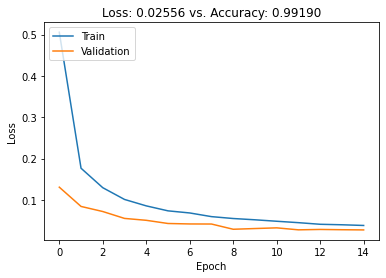

In [16]:
model_mnist = create_mnist_model("gap_shallow", (28, 28, 1), mnist_num_classes, mnist_train)

# model_mnist, history_mnist = load_model("gap_shallow")
start_time = time.clock()
history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))
# save_model(model_mnist, history_mnist, "gap_shallow")

model_mnist.summary()
score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)

plot_model_score(score_mnist, history_mnist.history)

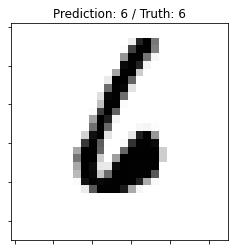

In [17]:
image, label, prediction, _ = get_prediction(model_mnist, mnist_test)
show_prediction(image, label, prediction)

#GEO

In [18]:
geo_dataset_proto = ("proto", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz", ["vertical", "diagonal", "ellipse"])
geo_dataset_simple = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_round = ("round", "https://geo-cam.s3-eu-west-1.amazonaws.com/rounddataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_threesixty = ("threesixty", "https://geo-cam.s3-eu-west-1.amazonaws.com/threesixtydataset_dataset.npz", ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150", "160", "170", "180"])

def get_geo_dataset(name, filepath):
  path = tf.keras.utils.get_file(name, filepath)
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [19]:
def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
       
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.3),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

18841600/18841002 [==============================] - 0s 0us/step
(28, 28)
1
x_train shape: (4200, 28, 28, 1)
4200 train samples
1800 test samples
Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


30/30 [==============================] - 3s 56ms/step - loss: 1.7719 - accuracy: 0.1629 - val_loss: 1.7017 - val_accuracy: 0.1405
Epoch 2/15
30/30 [==============================] - 1s 37ms/step - loss: 1.5914 - accuracy: 0.2922 - val_loss: 1.0913 - val_accuracy: 0.7333
Epoch 3/15
30/30 [==============================] - 1s 37ms/step - loss: 0.9560 - accuracy: 0.7276 - val_loss: 0.6591 - val_accuracy: 0.8071
Epoch 4/15
30/30 [==============================] - 1s 36ms/step - loss: 0.6665 - accuracy: 0.7599 - val_loss: 0.5057 - val_accuracy: 0.8571
Epoch 5/15
30/30 [==============================] - 1s 36ms/step - loss: 0.5238 - accuracy: 0.8200 - val_loss: 0.4229 - val_accuracy: 0.8905
Epoch 6/15
30/30 [==============================] - 1s 36ms/step - loss: 0.4475 - accuracy: 0.8724 - val_loss: 0.3459 - val_accuracy: 0.9333
Epoch 7/15
30/30 [==============================] - 1s 36ms/step - loss: 0.3752 - accuracy: 0.9069 - val_loss: 0.2916 - val_accuracy: 0.9333
Epoch 8/15
30/30 [======

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


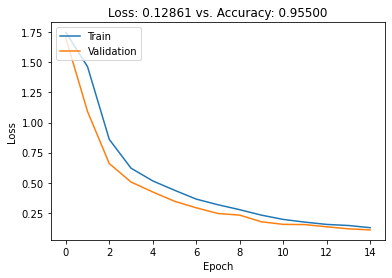

In [20]:
dataset = geo_dataset_simple
geo_train, geo_test = get_geo_dataset(dataset[0], dataset[1])
geo_train, geo_test = format_dataset(len(dataset[2]), geo_train, geo_test)
model_geo = create_geo_model("geocam", (28, 28, 1), len(dataset[2]))
# model_geo, history_geo = load_model("geo")

start_time = time.clock()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))
# save_model(model_geo, history_geo, "geo")

model_geo.summary()
score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)

plot_model_score(score_geo, history_geo.history)

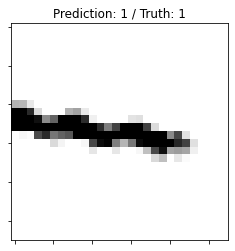

In [21]:
image, label, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, label, prediction)

# Transfer-learning


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1/20
422/422 [==============================] - 30s 69ms/step - loss: 1.8104 - accuracy: 0.3355 - val_loss: 1.0065 - val_accuracy: 0.6300
Epoch 2/20
422/422 [==============================] - 28s 66ms/step - loss: 0.8225 - accuracy: 0.7472 - val_loss: 0.5971 - val_accuracy: 0.8038
Epoch 3/20
422/422 [==============================] - 28s 66ms/step - loss: 0.5661 - accuracy: 0.8280 - val_loss: 0.6224 - val_accuracy: 0.7713
Epoch 4/20
422/422 [==============================] - 28s 67ms/step - loss: 0.4708 - accuracy: 0.8574 - val_loss: 0.6362 - val_accuracy: 0.7610
Epoch 5/20
422/422 [==============================] - 28s 66ms/step - loss: 0.4095 - accuracy: 0.8750 - val_loss: 0.5593 - val_accuracy: 0.7942
Epoch 6/20
422/422 [==============================] - 28s 66ms/step - loss: 0.3698 - accuracy: 0.8860 - val_loss: 0.3855 - val_accuracy: 0.8708
Epoch 7/20
422/422 [==============================] - 28s 66ms/step - loss: 0.3443 - accuracy: 0.8958 - val_loss: 0.3135 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)      

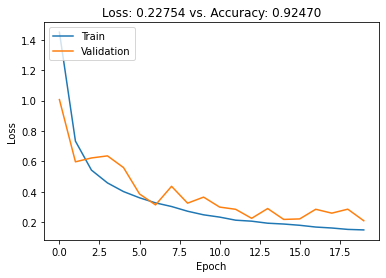

In [22]:
geo_layers = get_cam_layers(keras.models.clone_model(model_geo))
mnist_layers = get_cam_layers(keras.models.clone_model(model_mnist))

model_gcm = keras.Sequential()

for layer in geo_layers[0]:
  layer.trainable = False
  model_gcm.add(layer)

model_gcm.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.Dropout(0.4))
# model_gcm.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.GlobalAveragePooling2D())
model_gcm.add(layers.Dense(mnist_num_classes, activation="softmax"))

# for layer in mnist_layers[1]:
  # model_gcm.add(layer)

opt = keras.optimizers.Adam(learning_rate=0.002)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

start_time = time.clock()
history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=20, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))

score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
model_gcm.summary()
plot_model_score(score_gcm, history_geocam.history)

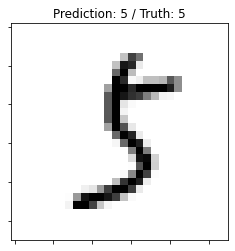

In [23]:
image, label, prediction, _ = get_prediction(model_gcm, mnist_test)
show_prediction(image, label, prediction)

# CAMs

In [24]:
def grad_cam_pp(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  heatmap_model = Model([model.inputs], [cam_layers[0][con_layer_idx].get_output_at(0), model.output])

  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
              conv_output, predictions = heatmap_model(np.expand_dims(image, 0))
              prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
              output = predictions[:, prediction_idx]
              conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, prediction_idx, (conv_first_grad, conv_second_grad, conv_third_grad)

In [25]:
def cam_1(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[1][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

# Experiments

conv output hash: B652990F1F101BBCBBFCEA9DF4AA3C7A180061FC46EE2AB35DAFB8822A4886F7


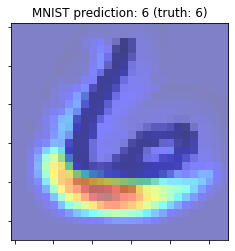

In [26]:
# debugging cams and values
test_ids = {
        "1": 3455,
        "4": 6195,
        "0": 3710,
        "6": 6187,
        "7": 6606,
        "5": 6148,
        "9": 5622,
    }

test_idx = 6
test_mnist_idx = test_ids[f"{test_idx}"]
test_mnist_image = mnist_test[0][test_mnist_idx]
# show_image(test_mnist_image)

# GCM (Transfer learned network - init geo, end mnist)
# gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_idx)
# gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_mnist_image, model_gcm, -3)
conv_output_hash = hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()

print(f"conv output hash: {conv_output_hash}")
title = f"MNIST prediction: {gcm_mnist_prediction} (truth: {test_idx})"
show_heatmap(test_mnist_image, gcm_mnist_cam, (28, 28, 1), True, title)

assert test_idx == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, gcm_mnist_prediction)

1st : vertical (100.00%)
2nd : lower_than (11.97%)
3rd : greather_than (4.13%)


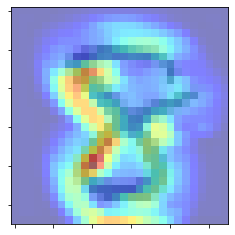

In [116]:
# prediction based on cam heatmap (not promissing)

test_image, test_label = get_sample(mnist_test)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_image, model_gcm)
heatmap = get_heatmap(gcm_mnist_cam, (28, 28)).reshape(28, 28, 1) * 255
prediction = predict(model_geo, heatmap)

labels = dataset[2]
sorted_indexes = np.flip(np.argsort(prediction[0]))
percentages = prediction[0] / prediction[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

plt.figure(facecolor='white')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(test_image.reshape(28, 28), alpha=0.5, cmap='Greys')
plt.imshow(heatmap.reshape(28, 28), cmap='jet', alpha=0.5)
plt.show()  

1st : ellipse (100.00%)
2nd : lower_than (14.56%)
3rd : horizontal (12.43%)


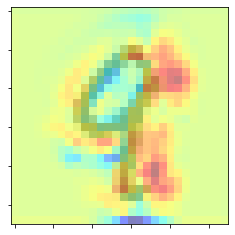

In [135]:
# prediction based on conv output
test_image, test_label = get_sample(mnist_test)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_image, model_gcm)
assert test_label == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, test_label)

# CAM for GEO NN (Knowledge Domain Network)
geo_layers = get_cam_layers(keras.models.clone_model(model_geo))
model_gcg = keras.Sequential()
for layer in geo_layers[1]:
  model_gcg.add(layer)

# Prediction
labels = dataset[2]
gcg_predictions = model_gcg(gcm_conv_output)
sorted_indexes = np.flip(np.argsort(gcg_predictions[0]))
percentages = gcg_predictions[0] / gcg_predictions[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

# Debug (CAM projection)
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, gcg_prediction_idx)
show_heatmap(test_image, gcg_mnist_cam, (28, 28, 1), True)

# Metrics

MAIN Accuracy: 0.14
[0] Accuracy: 0.56
[0] Precision: 0.31360000000000005
[0] Recall: 0.56
[0] F1 score: 0.40205128205128204
[1] Accuracy: 0.88
[1] Precision: 0.7744
[1] Recall: 0.88
[1] F1 score: 0.8238297872340425
[2] Accuracy: 0.82
[2] Precision: 0.6724
[2] Recall: 0.82
[2] F1 score: 0.738901098901099
[3] Accuracy: 0.14
[3] Precision: 0.019600000000000003
[3] Recall: 0.14
[3] F1 score: 0.0343859649122807
[4] Accuracy: 1.0
[4] Precision: 1.0
[4] Recall: 1.0
[4] F1 score: 1.0
[5] Accuracy: 0.88
[5] Precision: 0.7744
[5] Recall: 0.88
[5] F1 score: 0.8238297872340425


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

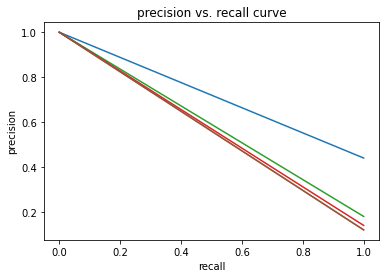

In [148]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

digit_decomposition_categories = ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"]
digits_descriptions = [
  ["ellipse"], #0
  ["vertical", "diagonal"], #1
  ["horizontal", "diagonal"], #2
  ["lower_than", "horizontal"], #3
  ["vertical", "horizontal"], #4
  ["greather_than", "vertical", "horizontal"], #5
  ["diagonal", "ellipse"], #6
  ["diagonal", "horizontal"], #7
  ["ellipse"], #8
  ["ellipse", "diagonal"], #9
]

validation_amount = 50
validation_idxs = np.random.choice(validation_amount, len(mnist_test[0]))

y_true, y_score = [], []
precision, recall = dict(), dict()
for i in range(validation_amount):
  validation_idx = validation_idxs[i]
  
  # true
  true_mnist_label = np.argmax(mnist_test[1][validation_idx])
  true_digit_decomposition_label = digits_descriptions[true_mnist_label][0]
  true_digit_decomposition_idx = digit_decomposition_categories.index(true_digit_decomposition_label)
  y_true.append(true_digit_decomposition_idx)

  # prediction
  test_mnist_image = mnist_test[0][validation_idx]
  gcm_mnist_cam, gcm_conv_output, _, _ = grad_cam_pp(test_mnist_image, model_gcm)
  
  #image = get_heatmap(gcm_mnist_cam, (28, 28)).reshape(28, 28, 1) * 255
  #prediction = predict(model_geo, image)

  prediction = model_gcg(gcm_conv_output)
  score_digit_decomposition_idx = digit_decomposition_categories.index(dataset[2][np.argmax(prediction)])
  y_score.append(score_digit_decomposition_idx)

y_true, y_score = np.array(y_true), np.array(y_score)

print(f"MAIN Accuracy: {accuracy_score(y_true, y_score)}")

# plot
plt.figure()

for i in range(len(digit_decomposition_categories)):
  a, b = np.int0(y_true == i), np.int0(y_score == i)
  
  print(f"[{i}] Accuracy: {accuracy_score(a, b)}")
  print(f"[{i}] Precision: {precision_score(a, b, average='weighted')}")
  print(f"[{i}] Recall: {recall_score(a, b, average='weighted')}")
  print(f"[{i}] F1 score: {f1_score(a, b, average='weighted')}")

  precision[i], recall[i], _ = precision_recall_curve(a, b)
  plt.plot(recall[i], precision[i])

plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision vs. recall curve")
plt.show()